## Goal

Funnel analysis allows to understand where/when our users abandon the website. It gives crucial insights on user behavior and on ways to improve the user experience. Also, it often allows to discover bugs.

## Challenge Description
You are looking at data from an e-commerce website. The site is very simple and has just 4 pages:
- Home page: when you come to the site for the first time, you can only land on the home page as a first page. 
- Search page: from a home page, the user can perform a search and land on the search page. 
- Payment page: from the search page, if the user clicks on a product, she will get to the payment page, where she is asked to provide payment information in order to buy that product. 
- Confirmation page: if she does decide to buy, she ends up on the confirmation page. 

The company CEO isn't very happy with the volume of sales and, especially, of sales coming from new users. Therefore, she asked you to investigate whether there is something wrong in the conversion funnel or, in general, if you could suggest how conversion rate can be improved. 

Specifically, she is interested in:
- A full picture of funnel conversion rate for both desktop and mobile.
- Some insights on what the product team should focus on in order to improve conversion rate as well as anything you might discover that could help improve conversion rate. 

In [1]:
# Importing all the necessary libraries
import numpy as np
import pandas as pd
from collections import Counter
from datetime import datetime
from scipy.stats import t
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, IsolationForest, StackingRegressor

import seaborn as sns
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet
import xgboost
from xgboost import plot_importance, XGBClassifier
import time
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedKFold
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, auc, roc_curve, classification_report,mutual_info_score, confusion_matrix, roc_auc_score, precision_score, f1_score, roc_curve, plot_confusion_matrix,plot_roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import math
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import DBSCAN

import optuna
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)


import plotly 
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import shap 
import missingno as msno

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from collections import Counter

from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping

C:\Users\yijia\anaconda3\envs\py3-TF2.0\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Load data set

In [49]:
user=pd.read_csv('user_table.csv')
home=pd.read_csv('home_page_table.csv').rename(columns = {"page":'home_page'})
search=pd.read_csv('search_page_table.csv').rename(columns = {"page":'search_page'})
payment=pd.read_csv('payment_page_table.csv').rename(columns = {"page":'payment_page'})
confirmation=pd.read_csv('payment_confirmation_table.csv').rename(columns = {"page":'confirmation_page'})

In [50]:
data = pd.merge(left = user, right = home, how = 'left', on = 'user_id')
data = pd.merge(left = data, right = search, how = 'left', on = 'user_id')
data = pd.merge(left = data, right = payment, how = 'left', on = 'user_id')
data = pd.merge(left = data, right = confirmation, how = 'left', on = 'user_id')
data.head()

,user_id,date,device,sex,home_page,search_page,payment_page,confirmation_page
0,450007,2015-02-28,Desktop,Female,home_page,NaN,NaN,NaN
1,756838,2015-01-13,Desktop,Male,home_page,NaN,NaN,NaN
2,568983,2015-04-09,Desktop,Male,home_page,search_page,NaN,NaN
3,190794,2015-02-18,Desktop,Female,home_page,search_page,NaN,NaN
4,537909,2015-01-15,Desktop,Male,home_page,NaN,NaN,NaN


In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90400 entries, 0 to 90399
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            90400 non-null  int64 
 1   date               90400 non-null  object
 2   device             90400 non-null  object
 3   sex                90400 non-null  object
 4   home_page          90400 non-null  object
 5   search_page        45200 non-null  object
 6   payment_page       6030 non-null   object
 7   confirmation_page  452 non-null    object
dtypes: int64(1), object(7)
memory usage: 6.2+ MB


In [52]:
data[['home_page','search_page', 'payment_page','confirmation_page']] = data[['home_page','search_page', 'payment_page','confirmation_page']].applymap(lambda x: 0 if pd.isnull(x) else 1)

In [53]:
data.head()

,user_id,date,device,sex,home_page,search_page,payment_page,confirmation_page
0,450007,2015-02-28,Desktop,Female,1,0,0,0
1,756838,2015-01-13,Desktop,Male,1,0,0,0
2,568983,2015-04-09,Desktop,Male,1,1,0,0
3,190794,2015-02-18,Desktop,Female,1,1,0,0
4,537909,2015-01-15,Desktop,Male,1,0,0,0


### A full picture of funnel conversion rate for both desktop and mobile

In [54]:
conv_ratio = pd.DataFrame(data[['search_page', 'payment_page','confirmation_page']].sum(axis = 0)/len(data))
conv_ratio.columns = ['Conversion']
conv_ratio = conv_ratio.reset_index()
conv_ratio

,index,Conversion
0,search_page,0.500000
1,payment_page,0.066704
2,confirmation_page,0.005000


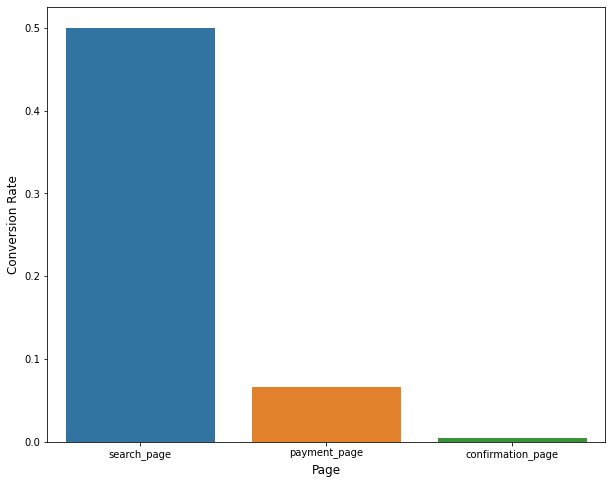

In [55]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.barplot(x='index', y='Conversion', data = conv_ratio, ax = ax)
ax.set_xlabel('Page', fontsize = 12)
ax.set_ylabel('Conversion Rate', fontsize = 12)
plt.show()

In [59]:
data.groupby('device')[['home_page','search_page', 'payment_page','confirmation_page']].sum()

,home_page,search_page,payment_page,confirmation_page
device,,,,
Desktop,60200,30100,3010,150
Mobile,30200,15100,3020,302


In [66]:
conv_rate_by_device = data.groupby('device')[['home_page','search_page', 'payment_page','confirmation_page']].agg('mean')
conv_rate_by_device = conv_rate_by_device.reset_index()
conv_rate_by_device

,device,home_page,search_page,payment_page,confirmation_page
0,Desktop,1.0,0.5,0.05,0.002492
1,Mobile,1.0,0.5,0.10,0.010000


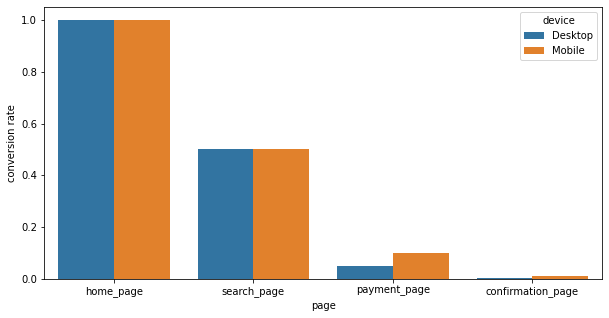

In [117]:
by_device = conv_rate_by_device.melt(id_vars=['device'], var_name='page', value_name='conversion rate')
fig, ax = plt.subplots(figsize = (10, 5))
sns.barplot(x = 'page', y='conversion rate', data=by_device, hue = 'device', ax=ax)
plt.show()

### A full picture of funnel conversion rate by sex

In [124]:
conv_rate_by_sex = data.groupby('sex')[['home_page','search_page', 'payment_page','confirmation_page']].agg('mean')
conv_rate_by_sex = conv_rate_by_sex.reset_index()
conv_rate_by_sex

,sex,home_page,search_page,payment_page,confirmation_page
0,Female,1.0,0.503073,0.068774,0.005347
1,Male,1.0,0.496944,0.064644,0.004655


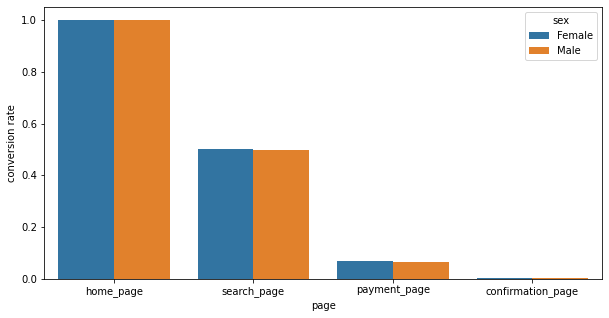

In [126]:
by_sex = conv_rate_by_sex.melt(id_vars=['sex'], var_name='page', value_name='conversion rate')
fig, ax = plt.subplots(figsize = (10, 5))
sns.barplot(x = 'page', y='conversion rate', data=by_sex, hue = 'sex', ax=ax)
plt.show()

In [128]:
data['date'] = pd.to_datetime(data['date'])

In [132]:
data['day'] = data['date'].map(lambda x: x.day)
data['month'] = data['date'].map(lambda x: x.month)
data['week'] = data['date'].map(lambda x: x.week)
data['wod'] = data['date'].map(lambda x: x.weekday())
data.head()

,user_id,date,device,sex,home_page,search_page,payment_page,confirmation_page,day,month,week,wod
0,450007,2015-02-28,Desktop,Female,1,0,0,0,28,2,9,5
1,756838,2015-01-13,Desktop,Male,1,0,0,0,13,1,3,1
2,568983,2015-04-09,Desktop,Male,1,1,0,0,9,4,15,3
3,190794,2015-02-18,Desktop,Female,1,1,0,0,18,2,8,2
4,537909,2015-01-15,Desktop,Male,1,0,0,0,15,1,3,3


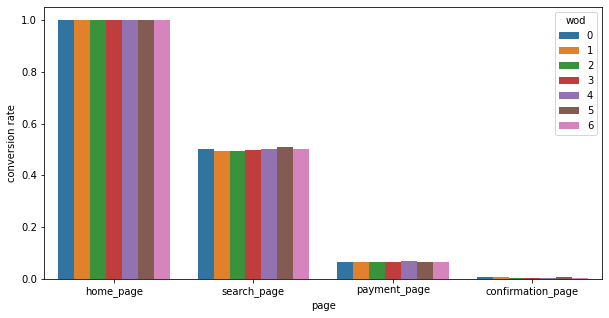

In [134]:
conv_rate_by_wod = data.groupby('wod')[['home_page','search_page', 'payment_page','confirmation_page']].agg('mean')
conv_rate_by_wod = conv_rate_by_wod.reset_index()
by_wod = conv_rate_by_wod.melt(id_vars=['wod'], var_name='page', value_name='conversion rate')
fig, ax = plt.subplots(figsize = (10, 5))
sns.barplot(x = 'page', y='conversion rate', data=by_wod, hue = 'wod', ax=ax)
plt.show()

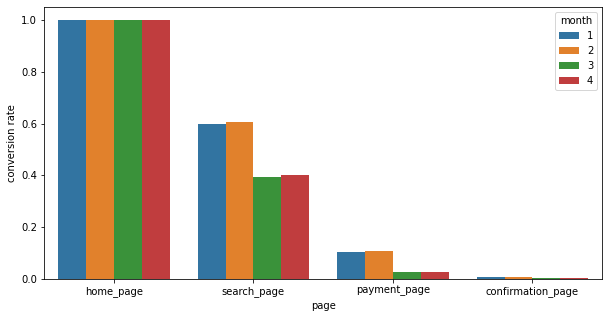

In [137]:
conv_rate_by_month = data.groupby('month')[['home_page','search_page', 'payment_page','confirmation_page']].agg('mean')
conv_rate_by_month = conv_rate_by_month.reset_index()
by_month = conv_rate_by_month.melt(id_vars=['month'], var_name='page', value_name='conversion rate')
fig, ax = plt.subplots(figsize = (10, 5))
sns.barplot(x = 'page', y='conversion rate', data=by_month, hue = 'month', ax=ax)
plt.show()